In [1]:
import sys 
import os 
import pickle
import numpy as np 
from astropy.io import fits
from astropy.coordinates import SkyCoord  
import astropy.units as u
import matplotlib.pylab as plt 
import pandas as pd 

# plt.rc('text', usetex=True) - Imperial cluster cannot find Latex
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
fits_image = fits.open('./data/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat.fits')
data = fits_image[1].data
fits_image.close()

# Notes
Important columns identified in the catalogue.

## Positions on the sky
- ALPHA_J2000 (deg)
- DELTA_J2000 (deg)

## Ellipticities and Weights
- e1
- e2
- weight

## Flux
- FLUX_GAAP_u (count)
- FLUX_GAAP_g (count)
- FLUX_GAAP_r (count)
- FLUX_GAAP_i (count)
- FLUX_GAAP_Z (count)
- FLUX_GAAP_Y (count)
- FLUX_GAAP_J (count)
- FLUX_GAAP_H (count)
- FLUX_GAAP_Ks (count)

## Flux Errors
- FLUXERR_GAAP_u (count)
- FLUXERR_GAAP_g (count)
- FLUXERR_GAAP_r (count)
- FLUXERR_GAAP_i (count)
- FLUXERR_GAAP_Z (count)
- FLUXERR_GAAP_Y (count)
- FLUXERR_GAAP_J (count)
- FLUXERR_GAAP_H (count)
- FLUXERR_GAAP_Ks (count)

## Magnitude
- MAG_GAAP_u (mag)
- MAG_GAAP_g (mag)
- MAG_GAAP_r (mag)
- MAG_GAAP_i (mag)
- MAG_GAAP_Z (mag)
- MAG_GAAP_Y (mag)
- MAG_GAAP_J (mag)
- MAG_GAAP_H (mag)
- MAG_GAAP_Ks (mag)

## Magnitude Error
- MAGERR_GAAP_u (mag)
- MAGERR_GAAP_g (mag)
- MAGERR_GAAP_r (mag)
- MAGERR_GAAP_i (mag)
- MAGERR_GAAP_Z (mag)
- MAGERR_GAAP_Y (mag)
- MAGERR_GAAP_J (mag)
- MAGERR_GAAP_H (mag)
- MAGERR_GAAP_Ks (mag)

## Magnitude Limit
- MAG_LIM_u (mag)
- MAG_LIM_g (mag)
- MAG_LIM_r (mag)
- MAG_LIM_i (mag)
- MAG_LIM_Z (mag)
- MAG_LIM_Y (mag)
- MAG_LIM_J (mag)
- MAG_LIM_H (mag)
- MAG_LIM_Ks (mag)

## Flag (all of them 0)
- FLAG_GAAP_u
- FLAG_GAAP_g
- FLAG_GAAP_r
- FLAG_GAAP_i
- FLAG_GAAP_Z
- FLAG_GAAP_Y
- FLAG_GAAP_J
- FLAG_GAAP_H
- FLAG_GAAP_Ks

## BPZ
- M_0 (reference magnitude for BPZ prior)
- Z_B (9 band BPZ redshift estimate - peak of posterior)
- Z_ML (9 band BPZ maximum likelihood redshift)
- Z_B_MIN (lower bound of the 68% confidence interval of Z_B)
- Z_B_MAX (upper bound of the 68% confidence interval of Z_B)

# Plot Objects on the Sky

We have chosen the first 500 000 objects in the catalogue. Takes a long time to plot all the samples. 

In [3]:
xarr, yarr = data['ALPHA_J2000'], data['DELTA_J2000']
nobjects = 500000
eq = SkyCoord(xarr[0:nobjects], yarr[0:nobjects], unit=u.deg)
gal = eq.galactic
colors = np.random.random((nobjects, 3))

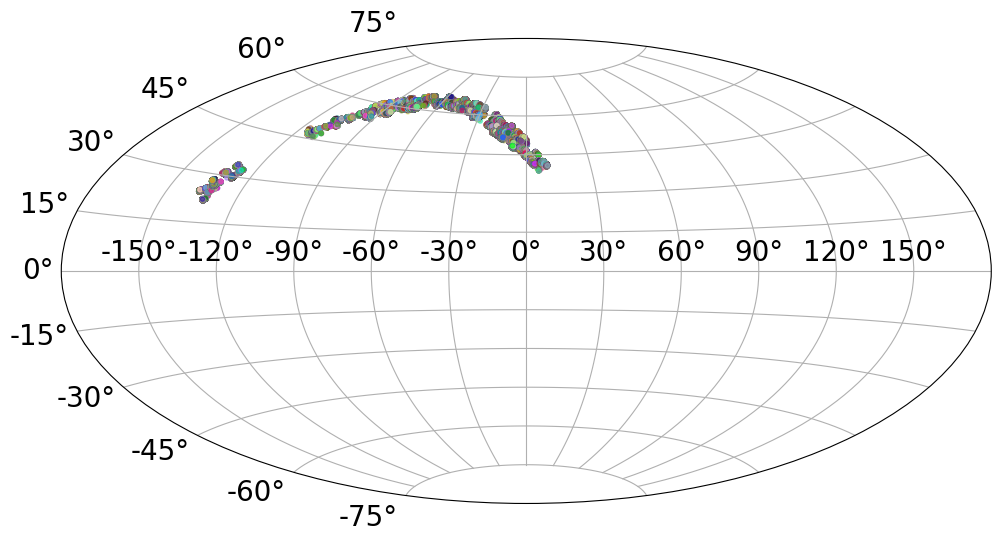

In [4]:
plt.figure(figsize = (12, 8))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s=10, c=colors, alpha=0.6, edgecolors=colors, rasterized=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig('plots/skymap.pdf', bbox_inches = 'tight')
plt.show()

## Plot bandpowers, covariance matrix and SOM redshift distributions

In [5]:
cosmo_data = fits.open('./data/KiDS1000_cosmis_shear_data_release/data_fits/bp_KIDS1000_BlindC_with_m_bias_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_goldclasses_Flag_SOM_Fid.fits')

In [6]:
# the covariance matrix 
covariance= cosmo_data['COVMAT'].data

# cosmic shear data vector
data_vector_PeeE = cosmo_data['PeeE'].data['VALUE']

# GGL data vector
data_vector_PneE = cosmo_data['PneE'].data['VALUE']

# the mid-redshift
redshift = cosmo_data["nz_source"].data['Z_MID']

# the heights 
h1 = cosmo_data["nz_source"].data['BIN1']
h2 = cosmo_data["nz_source"].data['BIN2']
h3 = cosmo_data["nz_source"].data['BIN3']
h4 = cosmo_data["nz_source"].data['BIN4']
h5 = cosmo_data["nz_source"].data['BIN5']

cosmo_data.close()

In [7]:
redshift = np.concatenate(([0], redshift))
h1 = np.concatenate(([0], h1))
h2 = np.concatenate(([0], h2))
h3 = np.concatenate(([0], h3))
h4 = np.concatenate(([0], h4))
h5 = np.concatenate(([0], h5))

In [8]:
n1 = h1 / np.trapz(h1, redshift)
n2 = h2 / np.trapz(h2, redshift)
n3 = h3 / np.trapz(h3, redshift)
n4 = h4 / np.trapz(h4, redshift)
n5 = h5 / np.trapz(h5, redshift)

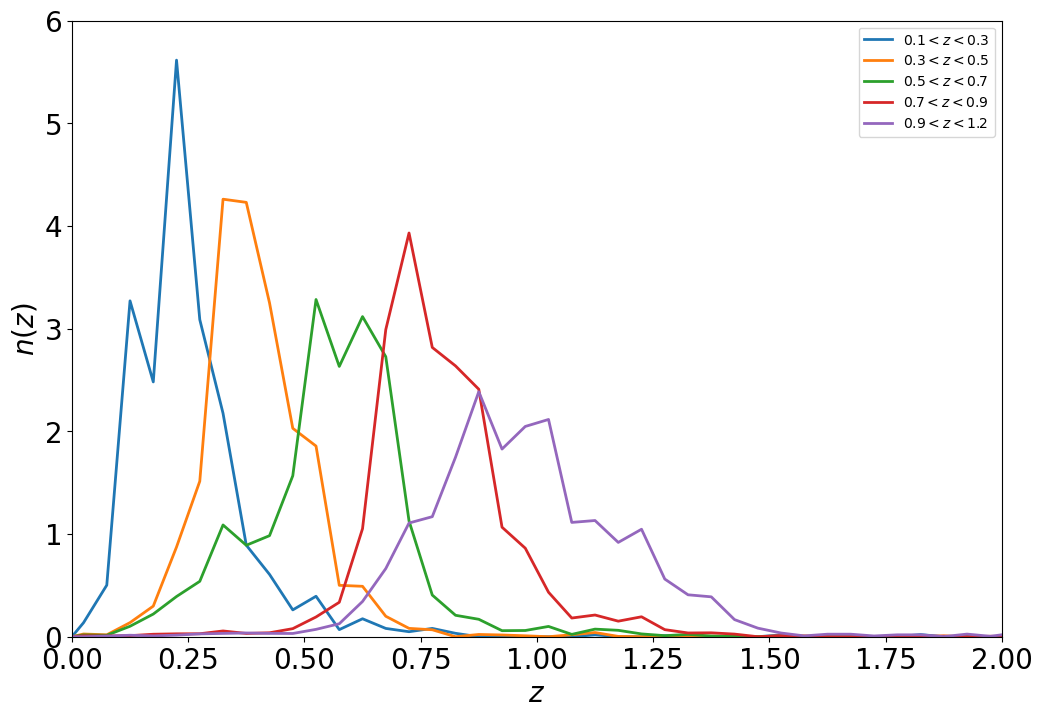

In [9]:
plt.figure(figsize = (12, 8))
plt.plot(redshift, n1, lw = 2, label = r'$0.1<z<0.3$')
plt.plot(redshift, n2, lw = 2, label = r'$0.3<z<0.5$')
plt.plot(redshift, n3, lw = 2, label = r'$0.5<z<0.7$')
plt.plot(redshift, n4, lw = 2, label = r'$0.7<z<0.9$')
plt.plot(redshift, n5, lw = 2, label = r'$0.9<z<1.2$')
plt.ylabel(r'$n(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.xlim(0.0, 2.0)
plt.ylim(0.0, 6.0)
plt.legend()
plt.show()

# Choosing Specific Columns

In [41]:
band = ['u', 'g', 'r', 'i', 'Z', 'Y', 'J', 'H', 'Ks']
flux_names = [f'FLUX_GAAP_{b}' for b in band]
flux_names_err = [f'FLUXERR_GAAP_{b}' for b in band]
mag_names = [f'MAG_GAAP_{b}' for b in band]
mag_names_err =  [f'MAGERR_GAAP_{b}' for b in band]
bpz_names = ['Z_B', 'M_0', 'Z_ML', 'Z_B_MIN', 'Z_B_MAX']
meta_names = ['ALPHA_J2000', 'DELTA_J2000', 'e1', 'e2', 'weight']

nbpz = len(bpz_names)
nmeta = len(meta_names)
nband = len(band)

In [42]:
fluxes = np.asarray([data[flux_names[i]] for i in range(nband)]).T
fluxes_err = np.asarray([data[flux_names_err[i]] for i in range(nband)]).T
mag = np.asarray([data[mag_names[i]] for i in range(nband)]).T
mag_err = np.asarray([data[mag_names_err[i]] for i in range(nband)]).T
bpz = np.asarray([data[mag_names_err[i]] for i in range(nbpz)]).T
meta = np.asarray([data[meta_names[i]] for i in range(nmeta)]).T

In [43]:
df_flux = pd.DataFrame(fluxes, columns = flux_names, dtype=np.float16)
df_flux_err = pd.DataFrame(fluxes_err, columns = flux_names_err, dtype=np.float16)
df_mag = pd.DataFrame(mag, columns = mag_names, dtype=np.float16)
df_mag_err = pd.DataFrame(mag_err, columns = mag_names_err, dtype=np.float16)
df_bpz = pd.DataFrame(bpz, columns = bpz_names, dtype=np.float16)
df_meta = pd.DataFrame(meta, columns = meta_names, dtype=np.float16)

## Idea about the size of the dataframes

In [48]:
def get_size_mb(dataframe: pd.DataFrame) -> float:
    print(f'Size of dataframe in MB is {sys.getsizeof(dataframe)/1024**2:.2f}')    

In [49]:
get_size_mb(df_flux)

Size of dataframe in MB is 364.99


In [50]:
get_size_mb(df_flux_err)

Size of dataframe in MB is 364.99


In [51]:
get_size_mb(df_mag)

Size of dataframe in MB is 364.99


In [52]:
get_size_mb(df_mag_err)

Size of dataframe in MB is 364.99


In [53]:
get_size_mb(df_bpz)

Size of dataframe in MB is 202.77


In [54]:
get_size_mb(df_meta)

Size of dataframe in MB is 202.77


## Example of the tabular format

In [56]:
df_flux.head()

,FLUX_GAAP_u,FLUX_GAAP_g,FLUX_GAAP_r,FLUX_GAAP_i,FLUX_GAAP_Z,FLUX_GAAP_Y,FLUX_GAAP_J,FLUX_GAAP_H,FLUX_GAAP_Ks
0,0.0,0.0,0.0,0.0,316.00,558.0,221.875,905.0,924.5
1,0.0,0.0,0.0,0.0,11008.00,14520.0,18288.000,24000.0,27664.0
2,0.0,0.0,0.0,0.0,1914.00,1557.0,2037.000,2146.0,5168.0
3,0.0,0.0,0.0,0.0,474.75,890.5,382.750,2218.0,856.5
4,0.0,0.0,0.0,0.0,2096.00,2520.0,4022.000,6220.0,9032.0


In [57]:
df_flux_err.head()

,FLUXERR_GAAP_u,FLUXERR_GAAP_g,FLUXERR_GAAP_r,FLUXERR_GAAP_i,FLUXERR_GAAP_Z,FLUXERR_GAAP_Y,FLUXERR_GAAP_J,FLUXERR_GAAP_H,FLUXERR_GAAP_Ks
0,0.0,0.0,0.0,0.0,161.000,381.0,424.75,1030.0,943.0
1,0.0,0.0,0.0,0.0,178.000,428.0,481.50,1200.0,1100.0
2,0.0,0.0,0.0,0.0,170.000,407.0,455.25,1130.0,1030.0
3,0.0,0.0,0.0,0.0,164.000,390.0,382.25,1060.0,971.0
4,0.0,0.0,0.0,0.0,120.125,280.5,275.00,886.5,702.0


In [58]:
df_mag.head()

,MAG_GAAP_u,MAG_GAAP_g,MAG_GAAP_r,MAG_GAAP_i,MAG_GAAP_Z,MAG_GAAP_Y,MAG_GAAP_J,MAG_GAAP_H,MAG_GAAP_Ks
0,99.00000,24.546875,24.421875,23.921875,23.718750,23.093750,24.109375,22.59375,22.578125
1,99.00000,22.593750,20.890625,20.328125,19.859375,19.562500,19.328125,19.03125,18.890625
2,24.40625,23.500000,22.937500,22.625000,21.750000,21.984375,21.703125,21.65625,20.703125
3,24.03125,24.671875,23.843750,23.953125,23.265625,22.593750,23.515625,21.62500,22.656250
4,24.81250,24.031250,23.062500,22.265625,21.640625,21.453125,20.968750,20.50000,20.093750


In [59]:
df_mag_err.head()

,MAGERR_GAAP_u,MAGERR_GAAP_g,MAGERR_GAAP_r,MAGERR_GAAP_i,MAGERR_GAAP_Z,MAGERR_GAAP_Y,MAGERR_GAAP_J,MAGERR_GAAP_H,MAGERR_GAAP_Ks
0,6.722656,0.219116,0.209717,0.302979,0.553223,0.741699,2.078125,1.235352,1.107422
1,1.298828,0.041321,0.009659,0.013008,0.017548,0.032013,0.028595,0.054260,0.043182
2,0.475098,0.089111,0.059204,0.099670,0.096436,0.283691,0.242676,0.571777,0.216309
3,0.324463,0.248291,0.127197,0.318604,0.375000,0.475586,1.084961,0.519043,1.231445
4,0.546387,0.129761,0.057159,0.061615,0.062225,0.120789,0.074280,0.154785,0.084412


In [60]:
df_bpz.head()

,Z_B,M_0,Z_ML,Z_B_MIN,Z_B_MAX
0,6.722656,0.219116,0.209717,0.302979,0.553223
1,1.298828,0.041321,0.009659,0.013008,0.017548
2,0.475098,0.089111,0.059204,0.099670,0.096436
3,0.324463,0.248291,0.127197,0.318604,0.375000
4,0.546387,0.129761,0.057159,0.061615,0.062225


In [61]:
df_meta.head()

,ALPHA_J2000,DELTA_J2000,e1,e2,weight
0,128.625,-1.964844,0.098511,0.471191,0.711426
1,128.625,-1.958984,0.257568,-0.295166,15.539062
2,128.625,-1.956055,-0.124817,0.164185,14.460938
3,128.625,-1.951172,0.185913,-0.180664,6.761719
4,128.625,-1.242188,-0.278320,0.182617,9.468750


## Save the files

In [63]:
def pickle_save(file: list, folder_name: str, file_name: str) -> None:
    """Stores a list in a folder.
    Args:
        list_to_store (list): The list to store.
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    """

    # create the folder if it does not exist
    os.makedirs(folder_name, exist_ok=True)

    # use compressed format to store data
    with open(folder_name + "/" + file_name + ".pkl", "wb") as f:
        pickle.dump(file, f)


def pickle_load(folder_name: str, file_name: str) -> pd.DataFrame:
    """Reads a list from a folder.
    Args:
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    Returns:
        pd.DataFrame: a pandas dataframe
    """

    with open(folder_name + "/" + file_name + ".pkl", "rb") as f:
         file = pickle.load(f)

    return file

In [65]:
# pickle_save(df_flux, 'data/processed', 'flux')
# pickle_save(df_flux_err, 'data/processed', 'flux_err')
# pickle_save(df_mag, 'data/processed', 'mag')
# pickle_save(df_mag_err, 'data/processed', 'mag_err')
# pickle_save(df_meta, 'data/processed', 'meta')
# pickle_save(df_bpz, 'data/processed', 'bpz')